In [1]:
# Imports
from datetime import datetime as dt
import numpy as np
import pandas as pd
import pickle
import json
import sklearn
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

# Custom imports
import algorithms
from utils import accessors, preprocess, validation


## Setup, load data and preprocess

In [2]:
np.random.seed(500)
show_outputs = True
run_split_search = True # If false, just load the results instead of running the algorithm


In [3]:
# File and location information
path = "dataset/"
add_file = "addresses.jsonl"
cit_file = "cities.jsonl"

# Load the datasets in pandas
address_df = accessors.load_data(path, add_file)#.sample(100)
cit_df = accessors.load_data(path, cit_file)

# Preprocess the datasets (remove punctuation and parse to lowercase)
address_df = preprocess.clean_strings(address_df, "address")
address_df = address_df.drop_duplicates()
cit_df = preprocess.clean_strings(cit_df, "city")
cit_df = cit_df.drop_duplicates()

if show_outputs:
    display(address_df)
    display(cit_df)


,address,country
0,mitterweg angath,AT
1,joseffranzhuterstraße 72 6020 innsbruck austria,AT
2,flirschberg flirsch österreich,AT
3,lochbödele landeck austria,AT
4,ainet 75 9951 ainet,AT
...,...,...
595490,allée claude erignac versailles,FR
595491,rue du jeu de paume villepreux,FR
595493,rue du cèdre morainvilliers,FR
595494,boissets france,FR


,city,country
0,kappl,AT
1,schmirn,AT
2,zams,AT
3,wattenberg,AT
4,polling in tirol,AT
...,...,...
77476,saintmesmin,FR
77477,vernouxenvivarais,FR
77478,sedzemaubecq,FR
77479,bulatpestivien,FR


### Quick data analytics

In [4]:
# Any nans in the dataset?
print(address_df.isna().sum())
print(cit_df.isna().sum())


address    0
country    0
dtype: int64
city       0
country    0
dtype: int64


<AxesSubplot:ylabel='country'>

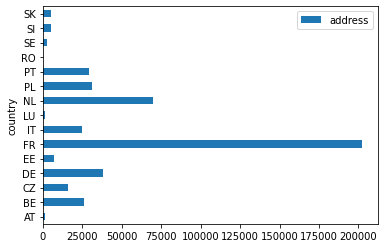

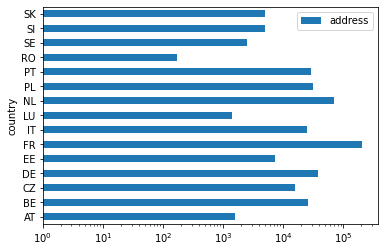

In [5]:
# Number of occurences of each country
countries = address_df.groupby("country").count()
countries.plot.barh()
countries.plot.barh(log=True)


# Simple search city df solution 
Split address into tokens and brute force search in city dataframe 

In [6]:
if run_split_search:
    #For now we will irngore this as it's slow
    t1 = dt.now()

    # Make a copy of address_df for split search
    add_df = address_df.copy(deep=True)

    # Initiate SplitSearch
    split_search = algorithms.SplitSearch(add_df, cit_df)

    # Run the algorithm and save results
    split_search.run()
    add_df_out = split_search.get_df() 
    add_df_out.to_csv('outputs/split_search_results.csv')

    # Get the accuracy and save results
    accuracy = split_search.get_accuracy() 
    accuracy.to_csv('outputs/split_search_accuracy.csv')

    # Get the cities that occur in multiple countries and save results
    dupe_cities = split_search.get_dupe_cities()
    np.save('outputs/dupe_cities.npy', dupe_cities) 

    t2 = dt.now()
    print("Time for calculation: {}".format((t2 - t1)))


In [7]:
if not run_split_search: 
    # Get the results from split search
    add_df_out = pd.read_csv('outputs/split_search_results.csv')

    # Get the accuracy and save results
    accuracy = pd.read_csv('outputs/split_search_accuracy.csv')

    # Get the cities that occur in multiple countries and save results
    dupe_cities = np.load('outputs/dupe_cities.npy', allow_pickle=True).item()

    
display(add_df_out)
display(accuracy)
print(dupe_cities)

,Unnamed: 0,address,country,country_pred
0,425348,"['avenue', 'de', 'luchon', 'gourdanpolignan']",FR,FR
1,582474,"['85280', 'la', 'ferrière']",FR,NaN
2,375324,"['impasse', 'de', 'chez', 'chasseriaud', '1', ...",FR,FR
3,369616,"['rue', 'paul', 'banaston', 'lisieux']",FR,FR
4,424836,"['route', 'de', 'gilis', 'cintegabelle']",FR,FR
...,...,...,...,...
95,534753,"['les', 'vernes', 'saintrémysurdurolle']",FR,FR
96,15445,"['ardooie', 'belgien']",BE,BE
97,342755,"['rue', 'de', 'rozoy', 'noircourt']",FR,FR
98,167312,"['gildehauser', 'damm', 'gronau', 'westf']",DE,NaN


,Unnamed: 0,country,correct,total,accuracy
0,0,BE,4,4,1.000000
1,1,CZ,0,1,0.000000
2,2,DE,4,5,0.800000
3,3,EE,0,5,0.000000
4,4,FR,38,50,0.760000
5,5,IT,4,6,0.666667
6,6,NL,10,10,1.000000
7,7,PL,8,8,1.000000
8,8,PT,6,7,0.857143
9,9,SE,1,1,1.000000


{'opava': ['SK', 'CZ'], 'berg': ['LU', 'FR'], 'vale': ['PT', 'SI']}


### Short-comings
- only using the city information, and not any of the other address data
- not all cities are one single string 
- special characters might change (e.g. ß -> ss) so the city will be missed
- some cities exist in multiple countries
- slow and not scalable

# Simple ML solution 
- First split the data into training and test datasets
- Encode the label
- Build a pipeline of different models and sets of hyper parameters to grid search over (including encoding the address)
- Extract the best model

## Train test split 
- Train on 80% of the data and use the remaining 20% to validate the approach
- Stratify over country since they are not all equally occurring in the dataset

In [8]:
# make a copy of address_df for split search
add_df = address_df.copy(deep=True)

# Train test split
train_x, test_x, train_y, test_y = sklearn.model_selection.train_test_split(
    add_df["address"],
    add_df["country"],
    stratify=add_df["country"],
    test_size=0.2,
)

# Combine the city dataset with the address dataset for training
train_x = pd.concat([train_x, cit_df["city"]])
train_y = pd.concat([train_y, cit_df["country"]])


### Label encoder

In [9]:
# Initialise label encoder (assigns numerical value to country str)
encoder = LabelEncoder()

# Encode the labels
train_y = encoder.fit_transform(train_y)
test_y = encoder.fit_transform(test_y)

np.save('outputs/encoded_classes.npy', encoder.classes_)

if show_outputs:
    print(train_y)
    print(test_y)


[3 3 9 ... 5 5 5]
[8 5 8 ... 5 8 2]


### Vectorizer, model and hyperparameter pipeline

In [10]:
# Set up sklearn pipline so we can grid search to find the best model and hyperparameters

pipeline = Pipeline(
    [
        ("tfidf", TfidfVectorizer()),
        ("clf", algorithms.ClfSwitcher()),
    ]
)

parameters = [
    {
        "clf__estimator": [SGDClassifier()],  # SVM if hinge loss / logreg if log loss
        "tfidf__max_df": (0.25, 0.5, 0.75, 1.0),
        "tfidf__stop_words": [None],
        "clf__estimator__penalty": ("l2", "elasticnet", "l1"),
        "clf__estimator__max_iter": [50, 80],
        "clf__estimator__tol": [1e-4],
        "clf__estimator__loss": ["hinge", "log_loss", "modified_huber"],
    },
    {
        "clf__estimator": [MultinomialNB()],
        "tfidf__max_df": (0.25, 0.5, 0.75, 1.0),
        "tfidf__stop_words": [None],
        "clf__estimator__alpha": (1e-2, 1e-3, 1e-1),
    },
]

gscv = GridSearchCV(
    pipeline, parameters, cv=5, n_jobs=12, return_train_score=False, verbose=3
)
gscv.fit(train_x, train_y)


Fitting 5 folds for each of 84 candidates, totalling 420 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', ClfSwitcher())]),
             n_jobs=12,
             param_grid=[{'clf__estimator': [SGDClassifier()],
                          'clf__estimator__loss': ['hinge', 'log_loss',
                                                   'modified_huber'],
                          'clf__estimator__max_iter': [50, 80],
                          'clf__estimator__penalty': ('l2', 'elasticnet', 'l1'),
                          'clf__estimator__tol': [0.0001],
                          'tfidf__max_df': (0.25, 0.5, 0.75, 1.0),
                          'tfidf__stop_words': [None]},
                         {'clf__estimator': [MultinomialNB(alpha=0.01)],
                          'clf__estimator__alpha': (0.01, 0.001, 0.1),
                          'tfidf__max_df': (0.25, 0.5, 0.75, 1.0),
                          'tfidf__stop_words': [None]}],
             verbose=3)

In [11]:
best_params = gscv.best_params_
print(best_params)
best_pipe = gscv.best_estimator_
print(best_pipe)

{'clf__estimator': MultinomialNB(alpha=0.01), 'clf__estimator__alpha': 0.01, 'tfidf__max_df': 0.25, 'tfidf__stop_words': None}
Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.25)),
                ('clf', ClfSwitcher(estimator=MultinomialNB(alpha=0.01)))])


In [12]:
print("Training set score: " + str(gscv.score(train_x, train_y)))
print("Test set score: " + str(gscv.score(test_x, test_y)))

Training set score: 0.9981112244027112
Test set score: 0.9973144000347932


In [13]:
# Save the model to disk
filename = 'outputs/finalized_model.sav'
pickle.dump(best_pipe, open(filename, 'wb'))

In [14]:
pred_y = encoder.inverse_transform(best_pipe.predict(test_x))
enc_test_y = encoder.inverse_transform(test_y)

df = pd.DataFrame(np.array([test_x, enc_test_y, pred_y]).T, columns = ['address', 'country', 'country_pred'])

accuracy_df = validation.class_accuracy(df, 'country', 'country_pred')
display(accuracy_df)

,country,correct,total,accuracy
0,AT,318,321,0.990654
1,BE,5189,5261,0.986314
2,CZ,3122,3131,0.997126
3,DE,7585,7604,0.997501
4,EE,1454,1454,1.000000
5,FR,40379,40409,0.999258
6,IT,4921,4930,0.998174
7,LU,257,284,0.904930
8,NL,13981,14021,0.997147
9,PL,6217,6221,0.999357


## Look at the incorrectly labeled addresses

In [15]:
falsely_predicted = df[~df['correct']]

#Display the incorrectly labeled countries and the counts of what labels they were assigned 
display(falsely_predicted.groupby(['country', 'country_pred'])
        .agg({'correct':'count'})
        .rename(columns={'correct':'count'}))


count
country country_pred       
AT      DE                2
        FR                1
BE      DE                1
        FR               30
        LU                1
        NL               40
CZ      IT                1
        PL                2
        SI                2
        SK                4
DE      BE                3
        CZ                1
        FR                1
        NL               14
FR      DE                6
        IT               14
        LU                1
        NL                2
        PT                4
        RO                1
        SI                2
IT      AT                4
        DE                2
        PT                2
        SI                1
LU      AT                1
        BE                2
        DE                3
        FR               20
        NL                1
NL      AT                1
        BE               24
        DE                4
        FR                8
        PT                2
        SE                1
PL      SI                2
        SK                2
PT      DE                2
        FR                4
        IT                2
        NL                1
SE      FR                2
SI      CZ                1
        IT                2
        PL                2
        SK                1
SK      CZ                9
        FR                2
        PL                2
        SI                4

[CV 4/5] END clf__estimator=SGDClassifier(), clf__estimator__loss=hinge, clf__estimator__max_iter=50, clf__estimator__penalty=l2, clf__estimator__tol=0.0001, tfidf__max_df=0.25, tfidf__stop_words=None;, score=0.971 total time=  25.3s
[CV 5/5] END clf__estimator=SGDClassifier(), clf__estimator__loss=hinge, clf__estimator__max_iter=50, clf__estimator__penalty=l2, clf__estimator__tol=0.0001, tfidf__max_df=0.75, tfidf__stop_words=None;, score=0.744 total time=  34.9s
[CV 5/5] END clf__estimator=SGDClassifier(), clf__estimator__loss=hinge, clf__estimator__max_iter=50, clf__estimator__penalty=elasticnet, clf__estimator__tol=0.0001, tfidf__max_df=0.25, tfidf__stop_words=None;, score=0.673 total time=  33.0s
[CV 2/5] END clf__estimator=SGDClassifier(), clf__estimator__loss=hinge, clf__estimator__max_iter=50, clf__estimator__penalty=elasticnet, clf__estimator__tol=0.0001, tfidf__max_df=1.0, tfidf__stop_words=None;, score=0.936 total time=  34.0s
[CV 4/5] END clf__estimator=SGDClassifier(), clf_

[CV 5/5] END clf__estimator=SGDClassifier(), clf__estimator__loss=hinge, clf__estimator__max_iter=50, clf__estimator__penalty=l2, clf__estimator__tol=0.0001, tfidf__max_df=0.5, tfidf__stop_words=None;, score=0.743 total time=  27.4s
[CV 5/5] END clf__estimator=SGDClassifier(), clf__estimator__loss=hinge, clf__estimator__max_iter=50, clf__estimator__penalty=l2, clf__estimator__tol=0.0001, tfidf__max_df=1.0, tfidf__stop_words=None;, score=0.743 total time=  32.4s
[CV 1/5] END clf__estimator=SGDClassifier(), clf__estimator__loss=hinge, clf__estimator__max_iter=50, clf__estimator__penalty=elasticnet, clf__estimator__tol=0.0001, tfidf__max_df=0.75, tfidf__stop_words=None;, score=0.933 total time=  32.3s
[CV 1/5] END clf__estimator=SGDClassifier(), clf__estimator__loss=hinge, clf__estimator__max_iter=50, clf__estimator__penalty=l1, clf__estimator__tol=0.0001, tfidf__max_df=0.25, tfidf__stop_words=None;, score=0.781 total time=  32.0s
[CV 5/5] END clf__estimator=SGDClassifier(), clf__estimato

[CV 2/5] END clf__estimator=SGDClassifier(), clf__estimator__loss=hinge, clf__estimator__max_iter=50, clf__estimator__penalty=l2, clf__estimator__tol=0.0001, tfidf__max_df=0.25, tfidf__stop_words=None;, score=0.972 total time=  26.2s
[CV 1/5] END clf__estimator=SGDClassifier(), clf__estimator__loss=hinge, clf__estimator__max_iter=50, clf__estimator__penalty=l2, clf__estimator__tol=0.0001, tfidf__max_df=1.0, tfidf__stop_words=None;, score=0.971 total time=  35.7s
[CV 4/5] END clf__estimator=SGDClassifier(), clf__estimator__loss=hinge, clf__estimator__max_iter=50, clf__estimator__penalty=elasticnet, clf__estimator__tol=0.0001, tfidf__max_df=0.5, tfidf__stop_words=None;, score=0.934 total time=  34.0s
[CV 2/5] END clf__estimator=SGDClassifier(), clf__estimator__loss=hinge, clf__estimator__max_iter=50, clf__estimator__penalty=l1, clf__estimator__tol=0.0001, tfidf__max_df=0.25, tfidf__stop_words=None;, score=0.827 total time=  31.7s
[CV 5/5] END clf__estimator=SGDClassifier(), clf__estimato

[CV 2/5] END clf__estimator=SGDClassifier(), clf__estimator__loss=hinge, clf__estimator__max_iter=50, clf__estimator__penalty=l2, clf__estimator__tol=0.0001, tfidf__max_df=0.75, tfidf__stop_words=None;, score=0.972 total time=  32.0s
[CV 4/5] END clf__estimator=SGDClassifier(), clf__estimator__loss=hinge, clf__estimator__max_iter=50, clf__estimator__penalty=elasticnet, clf__estimator__tol=0.0001, tfidf__max_df=0.25, tfidf__stop_words=None;, score=0.934 total time=  36.9s
[CV 1/5] END clf__estimator=SGDClassifier(), clf__estimator__loss=hinge, clf__estimator__max_iter=50, clf__estimator__penalty=elasticnet, clf__estimator__tol=0.0001, tfidf__max_df=1.0, tfidf__stop_words=None;, score=0.934 total time=  31.7s
[CV 2/5] END clf__estimator=SGDClassifier(), clf__estimator__loss=hinge, clf__estimator__max_iter=50, clf__estimator__penalty=l1, clf__estimator__tol=0.0001, tfidf__max_df=0.5, tfidf__stop_words=None;, score=0.799 total time=  30.4s
[CV 4/5] END clf__estimator=SGDClassifier(), clf__

[CV 2/5] END clf__estimator=SGDClassifier(), clf__estimator__loss=hinge, clf__estimator__max_iter=50, clf__estimator__penalty=l2, clf__estimator__tol=0.0001, tfidf__max_df=0.5, tfidf__stop_words=None;, score=0.972 total time=  27.8s
[CV 3/5] END clf__estimator=SGDClassifier(), clf__estimator__loss=hinge, clf__estimator__max_iter=50, clf__estimator__penalty=l2, clf__estimator__tol=0.0001, tfidf__max_df=1.0, tfidf__stop_words=None;, score=0.972 total time=  34.2s
[CV 5/5] END clf__estimator=SGDClassifier(), clf__estimator__loss=hinge, clf__estimator__max_iter=50, clf__estimator__penalty=elasticnet, clf__estimator__tol=0.0001, tfidf__max_df=0.5, tfidf__stop_words=None;, score=0.672 total time=  34.7s
[CV 4/5] END clf__estimator=SGDClassifier(), clf__estimator__loss=hinge, clf__estimator__max_iter=50, clf__estimator__penalty=l1, clf__estimator__tol=0.0001, tfidf__max_df=0.25, tfidf__stop_words=None;, score=0.782 total time=  32.0s
[CV 1/5] END clf__estimator=SGDClassifier(), clf__estimator

[CV 4/5] END clf__estimator=SGDClassifier(), clf__estimator__loss=hinge, clf__estimator__max_iter=50, clf__estimator__penalty=l2, clf__estimator__tol=0.0001, tfidf__max_df=0.5, tfidf__stop_words=None;, score=0.971 total time=  30.9s
[CV 2/5] END clf__estimator=SGDClassifier(), clf__estimator__loss=hinge, clf__estimator__max_iter=50, clf__estimator__penalty=elasticnet, clf__estimator__tol=0.0001, tfidf__max_df=0.25, tfidf__stop_words=None;, score=0.936 total time=  35.4s
[CV 3/5] END clf__estimator=SGDClassifier(), clf__estimator__loss=hinge, clf__estimator__max_iter=50, clf__estimator__penalty=elasticnet, clf__estimator__tol=0.0001, tfidf__max_df=0.75, tfidf__stop_words=None;, score=0.935 total time=  31.4s
[CV 5/5] END clf__estimator=SGDClassifier(), clf__estimator__loss=hinge, clf__estimator__max_iter=50, clf__estimator__penalty=l1, clf__estimator__tol=0.0001, tfidf__max_df=0.25, tfidf__stop_words=None;, score=0.272 total time=  33.8s
[CV 2/5] END clf__estimator=SGDClassifier(), clf_

[CV 1/5] END clf__estimator=SGDClassifier(), clf__estimator__loss=hinge, clf__estimator__max_iter=50, clf__estimator__penalty=l2, clf__estimator__tol=0.0001, tfidf__max_df=0.25, tfidf__stop_words=None;, score=0.971 total time=  25.2s
[CV 3/5] END clf__estimator=SGDClassifier(), clf__estimator__loss=hinge, clf__estimator__max_iter=50, clf__estimator__penalty=l2, clf__estimator__tol=0.0001, tfidf__max_df=0.75, tfidf__stop_words=None;, score=0.972 total time=  35.2s
[CV 2/5] END clf__estimator=SGDClassifier(), clf__estimator__loss=hinge, clf__estimator__max_iter=50, clf__estimator__penalty=elasticnet, clf__estimator__tol=0.0001, tfidf__max_df=0.5, tfidf__stop_words=None;, score=0.936 total time=  33.6s
[CV 3/5] END clf__estimator=SGDClassifier(), clf__estimator__loss=hinge, clf__estimator__max_iter=50, clf__estimator__penalty=elasticnet, clf__estimator__tol=0.0001, tfidf__max_df=1.0, tfidf__stop_words=None;, score=0.934 total time=  35.5s
[CV 1/5] END clf__estimator=SGDClassifier(), clf__

## Notes
- You can see that it's picking up the language. E.g. most of the BE addresses were labelled DE or FR (with one DE and one LU)

# General notes on this approach 
- NB is very fast so ver scalable
- SVM takes a while to fit and predict on large datasets
- SVMs do not perform well when target classes overlap 
- The results are not significantly better than the simple Naive Bayes approach (92.83 NB vs 93.01 SVM)